## Reinforcement Learning on Cliff Walking Problem

Reinforcement Learning: An Introduction
R. Sutton, and A. Barto. 
The MIT Press, Second edition, (2018)




Let us start by importing the related libraries

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt


In the following sections I will use a "copy" command to copy the action list and also for debugging purposes I want to see all the elements of a numpy regardless of the size of the matrix. To enable these the followings should be written:

In [2]:
import copy
np.set_printoptions(threshold = np.inf)

![Cliff Walking](https://cdn-images-1.medium.com/max/1600/1*cAezGWdRG9_3DXrKg3uftw.jpeg)

The task is simply to reach the point G by starting from point S in the map. However, there is a cliff we should avoid so that -100 reward incurs if a transition into the cliff is made. We will use two approaches to solve the problem as it can be seen from the picture. If we use **SARSA (State-Action-Reward-State-Action)** the agent will choose the 
safer path above. On the other side if we use **Q-Learning** the agent will choose relatively more dangerous but closer path. Note that these two methods are versions of **Temporal Difference** methods since they update the value function at each _time step_, not at each _episode_. Let's start with global methods.

In [3]:
def display2D(array):
    for row in array:
        # Loop over columns.
        for column in row:
            print(column.getSign(), end=" ")
        # getSign() basically returns 'O' to represent nonvisited element
        # 'C' to cliff and 'X' to represent visited element
        print(end="\n")

To display the rewards for debugging purpose

In [4]:
def displayRewards(array):
    for row in array:
        # Loop over columns
        for column in row:
            print(column.getReward(), end=" ")
        print(end='\n')

To handle the rewards the following method is written. Note that rewards are strictly taken from the book. Different rewards will result in different solutions so that **reward function implementation is one of the most important concepts in RL**. For this application the cliffs incurs -100 and other transitions incur -1. Also note that, generally rewards are implemented via a state-action matrix. However, for this problem actually what matters only is the state where you end up, not the action. Hence, I will embed the rewards into the states. This method will not work when the action also matters.

In [5]:
def handleRewards(array,last_row, column):
    # column - 2 equals to number of cliff elements
    for i in range (column - 2):
        array[last_row][i+1].setReward(-100)
    #array[last_row][column - 1].setReward(50)

The following method shifts an array by 1 to the left and adds a new element from right. Basically, we will smooth the curve by averaging the last n cumulative rewards. This method does not make anything different than a queue.

In [6]:
def shiftAndAddArray(arrayToShift, newElement):
    for i in range(len(arrayToShift) - 1):
        arrayToShift[i] = arrayToShift[i + 1]
    arrayToShift[len(arrayToShift) - 1] = newElement
    return arrayToShift

Let's implement our class States and the required methods before implementing SARSA and Q methods. However, the first thing is to create a global action_list to use.

In [7]:
actionList = [0, 1, 2, 3]       # 0 for right,1 for down, 2 for up, 3 for left

In [8]:
class States:
    #sign indicates the position if sign is C it is cliff, if S starting point F is finishing point
    # O is empty spot X is where the agent travels
    def __init__(self,sign,reward,row,column):
        self.sign = sign
        self.reward = reward
        self.row = row
        self.column = column

    # returns the reward of a particular state(note that states are enough for this problem for rewards)
    def getReward(self):
        return self.reward

    # returns the signs of a particular state
    def getSign(self):
        return self.sign

    # changes the sign of a particular state
    def changeSign(self,newSign):
        self.sign = newSign

    # changes the reward of a particular state
    def setReward(self,newReward):
        self.reward = newReward

    """Returns an action (encoded integer) by using a epsilon-greedy approach"""
    def eGreedy(self,Qvalue,epsilon,last_row_index, last_column_index): # returns action
        newActionList = actionList.copy()  # new action list to choose by eliminating prohibited actions
        if self.row == 0 and self.column == 0: # no up or left
            newActionList.remove(3)   # remove left
            newActionList.remove(2)   # remove up
        elif self.row == last_row_index and self.column == 0:  # no down or left
            newActionList.remove(3)   # remove left
            newActionList.remove(1)   # remove down
        elif self.row == 0 and self.column == last_column_index:  # no up or right
            newActionList.remove(0)   # remove right
            newActionList.remove(2)   # remove up
        elif self.row == last_row_index and self.column == last_column_index:  # no down or right
            newActionList.remove(0)   # remove right
            newActionList.remove(1)   # remove down
        # More general cases for prohibiting actions
        elif self.row == 0:  # no up
            newActionList.remove(2) # remove up
        elif self.row == last_row_index: # no down
            newActionList.remove(1) # remove down
        elif self.column == 0:  # no left
            newActionList.remove(3) # remove left
        elif self.column == last_column_index:  # no right
            newActionList.remove(0) # remove right

        probability = random.uniform(0, 1) # random number between 0 and 1 for epsilon greedy
        # To ensure exploration and exploitation e-greedy approach is used
        if probability < 1 - epsilon:  # greedy action
            return self.findMaxIndex(Qvalue, newActionList,last_row_index,last_column_index)
        else:  # random action
            return random.choice(newActionList)

    """Returns a pure greedy action without exploration"""
    def ePureGreedy(self,Qvalue,last_row_index, last_column_index):
        newActionList = actionList.copy()  # copy action list again
        if self.row == 0 and self.column == 0:  # no up or left
            newActionList.remove(3)  # remove left
            newActionList.remove(2)  # remove up
        elif self.row == last_row_index and self.column == 0:  # no down or left
            newActionList.remove(3)  # remove left
            newActionList.remove(1)  # remove down
        elif self.row == 0 and self.column == last_column_index:  # no up or right
            newActionList.remove(0)  # remove right
            newActionList.remove(2)  # remove up
        elif self.row == last_row_index and self.column == last_column_index:  # no down or right
            newActionList.remove(0)
            newActionList.remove(1)
        # More general cases
        elif self.row == 0:  # no up
            newActionList.remove(2)  # remove up
        elif self.row == last_row_index:  # no down
            newActionList.remove(1)  # remove down
        elif self.column == 0:  # no left
            newActionList.remove(3)  # remove left
        elif self.column == last_column_index:  # no right
            newActionList.remove(0)  # remove right

        return self.findMaxIndex(Qvalue, newActionList,last_row_index,last_column_index)

    # change the state according to the action
    def takeAction(self,array,action,Qvalue,last_row_index, last_column_index,epsilon):
        #  note that action is an integer value
        #  if 0 right, 1 down, 2 up, 3 left
        # the following 4 lines of code can be discarded by inputting newAction list to this method
        # I used a recursive approach for the solution by checking again whether motions are valid

        # row = 0 -> we can't go up - call eGreedy for a valid action
        if self.row == 0 and action == 2:  # if row 0 then up is not valid - call again eGreedy
            newAction = self.eGreedy(Qvalue, epsilon,last_row_index, last_column_index)
            return self.takeAction(array,newAction,Qvalue,last_row_index,last_column_index,epsilon)
        # row == last_row_index -> can't go down
        elif self.row == last_row_index and action == 1:
            newAction = self.eGreedy(Qvalue, epsilon,last_row_index, last_column_index)
            return self.takeAction(array, newAction,Qvalue,last_row_index,last_column_index,epsilon)
        # column == last_column_index can't go right
        elif self.column == last_column_index and action == 0:
            newAction = self.eGreedy(Qvalue, epsilon,last_row_index, last_column_index)
            return self.takeAction(array, newAction,Qvalue,last_row_index,last_column_index,epsilon)
        # column = 0 -> can't go left
        elif self.column == 0 and action == 3:
            newAction = self.eGreedy(Qvalue, epsilon,last_row_index, last_column_index)
            return self.takeAction(array, newAction,Qvalue, last_row_index, last_column_index,epsilon)

        else:  # if everything is valid
            if action == 0:  # right
                next_state = array[self.row][self.column+1]  # update the state
            elif action == 1:  # down
                next_state = array[self.row + 1][self.column]  # update the state
            elif action == 2:  # up
                next_state = array[self.row - 1][self.column]  # update the state
            elif action == 3:  # left
                next_state = array[self.row][self.column - 1]
        return next_state

    def findMaxIndex(self, Qvalue, actionList, last_row_index, last_column_index):  # returns index of maximum number, for maximum value action
        """2D array modeled as a vector such a way that from left-to-right and up-to-down state number is incremented
        i.e  0 - 1 - 2 - ..... - 11
             12 - 13 - ....... - 23
             24 - 25 - ....... - 35
             36 - 37 - ....... - 47

        Also state-action matrix is constrcuted and values Q values are stored in that in the following way
        i.e      Actions
        States   Right     Down    Up     Left
        ...       ...       ...     ...     ....
        State 11  -4.4      14.6    0.6    6.4
        ...       ...       ...     ...     ....
        if the model is 12 row and 4 columns then state 11 refers to the right-top point in which case the maximum
        action will be going down
        """
        maxIndex = np.argmax(Qvalue[self.row*12+self.column])
        return maxIndex

    #  checks whether the current state is terminal or not for ending the episode
    def isTerminal(self,last_row_index):
        # returns 1 if the current state is terminal - cliff or finish point
        if self.row == last_row_index and self.column > 0:
            return 1
        else:
            return 0

Now Let's start with SARSA. Before implementing, the algorithm can be given as follows from the book referenced above. Notice that while updating the policy, the same policy is used.

![Sarsa](https://cdn-images-1.medium.com/max/1600/1*7WZZgbJQr5lh86LRB2pbVg.png)

In [9]:

"""
@params
    array = state grid we constructed
    row_number = #rows of state grid
    column_number = #columns of state grid
    episodes = #episodes 
    steps = #steps within episodes
    alpha = learning rate
    gama = discount factor
    
"""
def applySarsa(array,row_number,column_number,episodes,steps,alpha,gama):
    state_number = row_number * column_number
    last_row_index = row_number - 1
    last_column_index = column_number - 1
    action_number = 4
    epsilon_sarsa = 0.2  # hyperparameter to tune actually
    # random initialization of the q table
    q_table = np.random.rand(state_number, action_number)
    # terminal state initialization
    q_table[state_number - 1][0] = 0
    q_table[state_number - 1][1] = 0
    q_table[state_number - 1][2] = 0
    q_table[state_number - 1][3] = 0
    rewardArray = []  # initialize - for plotting purpose
    episodeArray = [] # initialize - for plotting purpose
    windowing_average_samples = 40
    #  the number here is the window for taking moving average to smooth the graph
    averageRewardArray = np.zeros(windowing_average_samples)  #
    for i in range(episodes):  # loop for each episode
        """Following code segment can be used to try epsilon decaying strategy
            basically by decaying epsilon in couple of episodes we force the agent to follow only exploit
            not explore after a point. For this problem I did not use this approach..
            
            if(i % some_number_of_episodes == 0 and epsilon > some threshold):
              epsilon = epsilon - 0.01 """
        totalReward = 0
        episodeArray.append(i)
        current_state = array[last_row_index][0] # initial state S
        # choose action A from S using policy derived from Q
        action = current_state.eGreedy(q_table,epsilon_sarsa, last_row_index, last_column_index) 
        count = 0
        while count in range(steps) and current_state.isTerminal(last_row_index) == 0:
            count = count + 1
            # take action A, observe R,S'
            next_state = current_state.takeAction(array, action,q_table,last_row_index,last_column_index,epsilon_sarsa)
            reward_got = next_state.getReward()
            totalReward = totalReward + reward_got
            # choose A' from S' using policy derived from Q
            followingAction = next_state.eGreedy(q_table,epsilon_sarsa,last_row_index, last_column_index)
            q_table_next = q_table[((next_state.row)*12)+next_state.column][followingAction]
            q_table_current = q_table[((current_state.row)*12)+current_state.column][action]
            # update of the q method
            q_table[((current_state.row)*12)+current_state.column][action] = q_table_current + alpha*(reward_got +
                                                                                gama*q_table_next - q_table_current)
            # update the state
            current_state = next_state
            action = followingAction
        averageRewardArray = shiftAndAddArray(averageRewardArray, totalReward)
        valueToDraw = np.sum(averageRewardArray) / np.count_nonzero(averageRewardArray)
        rewardArray.append(valueToDraw)
    print("Sarsa TRAINING IS OVER")
    # draw the final path
    drawPath(array, q_table,last_row_index,last_column_index, epsilon_sarsa)
    # clip a segment because they corrupt the moving average
    episodeArray = episodeArray[10:]
    rewardArray = rewardArray[10:]
    # plotting
    plt.plot(episodeArray, rewardArray)
    plt.xlabel('episodes')
    plt.ylabel('Total reward(smoothed)')
    print(averageRewardArray)



The algorithm for Q learning is as follows. Notice that while updating the Q value greedy policy is used which is the only difference from SARSA. 

![Q](https://cdn-images-1.medium.com/max/1600/1*d203n7cIso731qhJ7eOAkg.png)

In [10]:

"""
@params
    array = state grid we constructed
    row_number = #rows of state grid
    column_number = #columns of state grid
    episodes = #episodes 
    steps = #steps within episodes
    alpha = learning rate
    gama = discount factor

"""

def applyQlearning(array,row_number,column_number,episodes,steps,alpha,gama):
    epsilon_q = 0.1
    state_number = row_number * column_number
    last_row_index = row_number - 1
    last_column_index = column_number - 1
    action_number = 4
    q_table = np.random.rand(state_number, action_number)
    # terminal state initialization
    q_table[state_number - 1][0] = 0
    q_table[state_number - 1][1] = 0
    q_table[state_number - 1][2] = 0
    q_table[state_number - 1][3] = 0
    rewardArray = []
    episodeArray = []
    #   averageRewardArray = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    windowing_average_samples = 40
    averageRewardArray = np.zeros(windowing_average_samples)
    for i in range(episodes):  # loop for each episode
        step = 0
        #     if (i % 50 == 0 and epsilonNew > 0.01):
         #   epsilonNew = epsilonNew - 0.01
        current_state = array[3][0]  # initialize S
        count = 0
        totalReward = 0
        episodeArray.append(i)
        while (count in range(steps) and current_state.isTerminal(last_row_index) == 0):
            step = step + 1
            count = count + 1
            # choose action A from S using policy derived from Q
            action = current_state.eGreedy(q_table,epsilon_q, last_row_index,last_column_index)
            # take action A, observe R,S'
            next_state = current_state.takeAction(array, action, q_table,last_row_index,last_column_index,epsilon_q)
            reward_got = next_state.getReward()
            totalReward = totalReward + reward_got
            actionMax = next_state.ePureGreedy(q_table,last_row_index,last_column_index)
            q_table_max = q_table[(next_state.row * column_number) + next_state.column][actionMax]
            q_table_current = q_table[(current_state.row * column_number) + current_state.column][action]
            q_table[(current_state.row * column_number) + current_state.column][action] = q_table_current +\
                                            alpha * (reward_got + (gama * q_table_max) - q_table_current)  # update
            current_state = next_state
        averageRewardArray = shiftAndAddArray(averageRewardArray, totalReward)
        valueToDraw = np.sum(averageRewardArray) / np.count_nonzero(averageRewardArray)
        rewardArray.append(valueToDraw)
    print("Q TRAINING IS OVER")
    episodeArray = episodeArray[10:]
    rewardArray = rewardArray[10:]
    drawPath(array, q_table,last_row_index,last_column_index,epsilon_q)
    plt.plot(episodeArray, rewardArray)
    plt.legend(['SARSA','Q learning'])
    print(averageRewardArray)
    plt.title(f'Smoothed by averaging {windowing_average_samples} successive episodes')
    # limitting the overall boundary to have a nice vision
    plt.ylim((-120, 0))
    plt.show()



These codes also contain plotting part. Therefore the last thing to do is simply drawing the path at the end of the training.


In [11]:
 #  this is for the test after the training
def drawPath(array,Qvalue,last_row_index, last_column_index,epsilon):
    current_state = array[last_row_index][0]  # initial state
    greedyAction = current_state.ePureGreedy(Qvalue,last_row_index,last_column_index)  # action is determined
    while(current_state.isTerminal(last_row_index) == 0):
        next_state = current_state.takeAction(array,greedyAction,Qvalue,last_row_index, last_column_index,epsilon)
        next_state.changeSign("X")
        followingAction = next_state.ePureGreedy(Qvalue,last_row_index, last_column_index)
        current_state = next_state
        greedyAction = followingAction
    display2D(array)

The main method can be given as follows:


O O O O O O O O O O O O 
O O O O O O O O O O O O 
O O O O O O O O O O O O 
O O O O O O O O O O O O 
OK HERE WE STOP
O O O O O O O O O O O O 
O O O O O O O O O O O O 
O O O O O O O O O O O O 
S C C C C C C C C C C F 
-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 
-1 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -1 
CONSTRUCTED
Sarsa TRAINING IS OVER
X X X X X X X X X X X O 
X O O O O O O O O O X X 
X O O O O O O O O O O X 
S C C C C C C C C C C X 
[ -17.  -19.  -21.  -21.  -21.  -23. -114. -100.  -19.  -23.  -21.  -27.
  -25.  -39.  -23. -100.  -23.  -21.  -17.  -23.  -19.  -23.  -29.  -17.
  -25.  -23.  -19.  -43.  -33.  -23.  -25.  -27.  -27.  -19. -100.  -25.
  -21.  -21.  -27.  -21.]
Q TRAINING IS OVER
O O O O O O O O O O O O 
O O O O O O O O O O O O 
X X X X X X X X X X X X 
S C C C C C C C C C C X 
[ -13. -114. -102. -102.  -13.  -15. -104.  -13. -100.  -13.  -15.  -13.
  -13. -100.  -15.  -13. -105.  -13.  -13.  

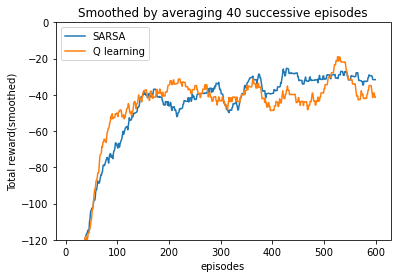

In [12]:
def main():
    episode_number = 600
    steps = 500
    gama = 0.9
    alpha = 0.25
    row_number = 4
    column_number = 12
    #construct the environment here q values are random integers
    stateGrid = [[States('O',-1,y,x) for x in range (column_number)] for y in range(row_number)]
    #print(random.choice(actionList)) this code segment changes a random action from the list
    display2D(stateGrid)
    print("OK HERE WE STOP")
    stateGrid[row_number - 1][0].changeSign('S')
    stateGrid[row_number - 1][column_number - 1].changeSign('F')
    for i in range(10):
        stateGrid[row_number - 1][i+1].changeSign('C')
    #this loop displays the two d array in a neat format
    display2D(stateGrid)
    #construction stopped here
    handleRewards(stateGrid, row_number - 1, column_number)
    displayRewards(stateGrid)
    print("CONSTRUCTED")
    stateGrid2 = copy.deepcopy(stateGrid)
    applySarsa(stateGrid, row_number, column_number, episode_number, steps, alpha, gama)
    applyQlearning(stateGrid2, row_number, column_number, episode_number, steps, alpha, gama)

if __name__ == "__main__":
    main()


As it can be seen here at first the agent constantly falls to the cliff so that the reward is significant low. After nearly 100 episodes the agent learns and average reward increases. With Q-Learning agent takes the closer but dangerous road, with Sarsa it takes the safest but long path. İn terms of average reward at the end of the training, since SARSA cares safety its average is greater than Q-Learning.